<a href="https://www.kaggle.com/code/kapusharinka/spam-ham-emails?scriptVersionId=125495190" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/corpora/corpora/wordnet/data.adj
/kaggle/input/corpora/corpora/wordnet/LICENSE
/kaggle/input/corpora/corpora/wordnet/index.adj
/kaggle/input/corpora/corpora/wordnet/README
/kaggle/input/corpora/corpora/wordnet/verb.exc
/kaggle/input/corpora/corpora/wordnet/index.adv
/kaggle/input/corpora/corpora/wordnet/index.verb
/kaggle/input/corpora/corpora/wordnet/data.verb
/kaggle/input/corpora/corpora/wordnet/lexnames
/kaggle/input/corpora/corpora/wordnet/data.noun
/kaggle/input/corpora/corpora/wordnet/noun.exc
/kaggle/input/corpora/corpora/wordnet/index.noun
/kaggle/input/corpora/corpora/wordnet/adj.exc
/kaggle/input/corpora/corpora/wordnet/index.sense
/kaggle/input/corpora/corpora/wordnet/adv.exc
/kaggle/input/corpora/corpora/wordnet/cntlist.rev
/kaggle/input/corpora/corpora/wordnet/data.adv
/kaggle/input/corpora/corpora/wordnet/citation.bib
/kaggle/input/email-spam-dataset/lingSpam.csv
/kaggle/input/email-spam-dataset/enronSpamSubset.csv
/kaggle/input/email-spam-dataset/completeS

In [2]:
data1 = pd.read_csv('/kaggle/input/email-spam-dataset/lingSpam.csv')
data1.info()
data1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2605 entries, 0 to 2604
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2605 non-null   int64 
 1   Body        2605 non-null   object
 2   Label       2605 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.2+ KB


,Unnamed: 0,Body,Label
0,0,Subject: great part-time or summer job !\n \n ...,1
1,1,Subject: auto insurance rates too high ?\n \n ...,1
2,2,Subject: do want the best and economical hunti...,1
3,3,Subject: email 57 million people for $ 99\n \n...,1
4,4,Subject: do n't miss these !\n \n attention ! ...,1


In [3]:
data2 = pd.read_csv('/kaggle/input/email-spam-dataset/enronSpamSubset.csv')
data2.info()
data2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    10000 non-null  int64 
 1   Unnamed: 0.1  10000 non-null  int64 
 2   Body          10000 non-null  object
 3   Label         10000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 312.6+ KB


,Unnamed: 0,Unnamed: 0.1,Body,Label
0,2469,2469,Subject: stock promo mover : cwtd\n * * * urge...,1
1,5063,5063,Subject: are you listed in major search engine...,1
2,12564,12564,"Subject: important information thu , 30 jun 20...",1
3,2796,2796,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,1468,1468,"Subject: "" bidstogo "" is places to go , things...",1


In [4]:
data3 = pd.read_csv('/kaggle/input/email-spam-dataset/completeSpamAssassin.csv')
data3.info()
data3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6046 non-null   int64 
 1   Body        6045 non-null   object
 2   Label       6046 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 141.8+ KB


,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


In [5]:
# delete unneeded columns
data1.drop("Unnamed: 0",inplace=True,axis=1)
data2.drop(["Unnamed: 0","Unnamed: 0.1"],inplace=True,axis=1)
data3.drop("Unnamed: 0",inplace=True,axis=1)

In [6]:
# concatenate data
data = pd.concat([data1,data2,data3],axis=0)
# remove missing values (NaN)
data.dropna(inplace=True)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18650 entries, 0 to 6045
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    18650 non-null  object
 1   Label   18650 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 437.1+ KB


,Body,Label
0,Subject: great part-time or summer job !\n \n ...,1
1,Subject: auto insurance rates too high ?\n \n ...,1
2,Subject: do want the best and economical hunti...,1
3,Subject: email 57 million people for $ 99\n \n...,1
4,Subject: do n't miss these !\n \n attention ! ...,1


# Text preprocessing

In [7]:
emails = data["Body"]

In [8]:
# lowering case
emails = [text.lower() for text in emails]
emails[0]

'subject: great part-time or summer job !\n \n * * * * * * * * * * * * * * * we have display boxes with credit applications that we need to place in the small owner-operated stores in your area . here is what you do : 1 . introduce yourself to the store owner or manager . 2 . use our 90 % effective script which tells them how this little display box will save their customers hundreds of dollars , be a drawing card for their business , and make them from $ 5 . 00 to $ 15 . 00 or more for every app sent in . 3 . find a good spot on the counter , place the box there , and say that nothing more need be done , all you need is his name and address so the company can send him the commission checks . your compensaation will be $ 10 for every box you place . by becoming a representative you could also earn a commission of $ 10 for each application that came from that store . that is of course a much more profitable plan , as it will pay you for months or years for a very small effort . call 1-8

In [9]:
# removal of special characters and numbers
import re
emails = [re.sub("[^a-zA-Z]"," ",text) for text in emails]
emails[0]

'subject  great part time or summer job                                    we have display boxes with credit applications that we need to place in the small owner operated stores in your area   here is what you do       introduce yourself to the store owner or manager       use our      effective script which tells them how this little display box will save their customers hundreds of dollars   be a drawing card for their business   and make them from          to           or more for every app sent in       find a good spot on the counter   place the box there   and say that nothing more need be done   all you need is his name and address so the company can send him the commission checks   your compensaation will be      for every box you place   by becoming a representative you could also earn a commission of      for each application that came from that store   that is of course a much more profitable plan   as it will pay you for months or years for a very small effort   call      

In [10]:
# removal of extra spaces
emails = [re.sub(" +", " ", text) for text in emails]
emails[0]

'subject great part time or summer job we have display boxes with credit applications that we need to place in the small owner operated stores in your area here is what you do introduce yourself to the store owner or manager use our effective script which tells them how this little display box will save their customers hundreds of dollars be a drawing card for their business and make them from to or more for every app sent in find a good spot on the counter place the box there and say that nothing more need be done all you need is his name and address so the company can send him the commission checks your compensaation will be for every box you place by becoming a representative you could also earn a commission of for each application that came from that store that is of course a much more profitable plan as it will pay you for months or years for a very small effort call code hours to receive the details to be removed from our mailing list type b hotmail com in the to area and remove 

In [11]:
# removal of hyperlinks
emails = [re.sub(r"http\S+", "", text) for text in emails]

# removal of HTML tags
emails = [re.sub(r"'<.*?>'", "", text) for text in emails]
emails[0]

'subject great part time or summer job we have display boxes with credit applications that we need to place in the small owner operated stores in your area here is what you do introduce yourself to the store owner or manager use our effective script which tells them how this little display box will save their customers hundreds of dollars be a drawing card for their business and make them from to or more for every app sent in find a good spot on the counter place the box there and say that nothing more need be done all you need is his name and address so the company can send him the commission checks your compensaation will be for every box you place by becoming a representative you could also earn a commission of for each application that came from that store that is of course a much more profitable plan as it will pay you for months or years for a very small effort call code hours to receive the details to be removed from our mailing list type b hotmail com in the to area and remove 

In [12]:
# tokenization
import nltk
emails = [nltk.word_tokenize(text) for text in emails]
emails[0]

['subject',
 'great',
 'part',
 'time',
 'or',
 'summer',
 'job',
 'we',
 'have',
 'display',
 'boxes',
 'with',
 'credit',
 'applications',
 'that',
 'we',
 'need',
 'to',
 'place',
 'in',
 'the',
 'small',
 'owner',
 'operated',
 'stores',
 'in',
 'your',
 'area',
 'here',
 'is',
 'what',
 'you',
 'do',
 'introduce',
 'yourself',
 'to',
 'the',
 'store',
 'owner',
 'or',
 'manager',
 'use',
 'our',
 'effective',
 'script',
 'which',
 'tells',
 'them',
 'how',
 'this',
 'little',
 'display',
 'box',
 'will',
 'save',
 'their',
 'customers',
 'hundreds',
 'of',
 'dollars',
 'be',
 'a',
 'drawing',
 'card',
 'for',
 'their',
 'business',
 'and',
 'make',
 'them',
 'from',
 'to',
 'or',
 'more',
 'for',
 'every',
 'app',
 'sent',
 'in',
 'find',
 'a',
 'good',
 'spot',
 'on',
 'the',
 'counter',
 'place',
 'the',
 'box',
 'there',
 'and',
 'say',
 'that',
 'nothing',
 'more',
 'need',
 'be',
 'done',
 'all',
 'you',
 'need',
 'is',
 'his',
 'name',
 'and',
 'address',
 'so',
 'the',
 'co

In [13]:
# removal of stopwords
stopwords = nltk.corpus.stopwords.words("english")
emails = [[word for word in text if word not in stopwords] for text in emails]
emails[0]

['subject',
 'great',
 'part',
 'time',
 'summer',
 'job',
 'display',
 'boxes',
 'credit',
 'applications',
 'need',
 'place',
 'small',
 'owner',
 'operated',
 'stores',
 'area',
 'introduce',
 'store',
 'owner',
 'manager',
 'use',
 'effective',
 'script',
 'tells',
 'little',
 'display',
 'box',
 'save',
 'customers',
 'hundreds',
 'dollars',
 'drawing',
 'card',
 'business',
 'make',
 'every',
 'app',
 'sent',
 'find',
 'good',
 'spot',
 'counter',
 'place',
 'box',
 'say',
 'nothing',
 'need',
 'done',
 'need',
 'name',
 'address',
 'company',
 'send',
 'commission',
 'checks',
 'compensaation',
 'every',
 'box',
 'place',
 'becoming',
 'representative',
 'could',
 'also',
 'earn',
 'commission',
 'application',
 'came',
 'store',
 'course',
 'much',
 'profitable',
 'plan',
 'pay',
 'months',
 'years',
 'small',
 'effort',
 'call',
 'code',
 'hours',
 'receive',
 'details',
 'removed',
 'mailing',
 'list',
 'type',
 'b',
 'hotmail',
 'com',
 'area',
 'remove',
 'subject',
 'area'

Stemming or lemmatization - lemmatizators are slower, but change tenses and nouns. Use the Wordnet lemmatizer, but with POS tag) 

In [14]:
# lemmatization
nltk.data.path.append('/kaggle/input/corpora/')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
emails = [[lemmatizer.lemmatize(word) for word in text] for text in emails]
emails[0]

['subject',
 'great',
 'part',
 'time',
 'summer',
 'job',
 'display',
 'box',
 'credit',
 'application',
 'need',
 'place',
 'small',
 'owner',
 'operated',
 'store',
 'area',
 'introduce',
 'store',
 'owner',
 'manager',
 'use',
 'effective',
 'script',
 'tell',
 'little',
 'display',
 'box',
 'save',
 'customer',
 'hundred',
 'dollar',
 'drawing',
 'card',
 'business',
 'make',
 'every',
 'app',
 'sent',
 'find',
 'good',
 'spot',
 'counter',
 'place',
 'box',
 'say',
 'nothing',
 'need',
 'done',
 'need',
 'name',
 'address',
 'company',
 'send',
 'commission',
 'check',
 'compensaation',
 'every',
 'box',
 'place',
 'becoming',
 'representative',
 'could',
 'also',
 'earn',
 'commission',
 'application',
 'came',
 'store',
 'course',
 'much',
 'profitable',
 'plan',
 'pay',
 'month',
 'year',
 'small',
 'effort',
 'call',
 'code',
 'hour',
 'receive',
 'detail',
 'removed',
 'mailing',
 'list',
 'type',
 'b',
 'hotmail',
 'com',
 'area',
 'remove',
 'subject',
 'area',
 'new',
 'e

In [15]:
# word cloud with the most frequent words
# TF-IDF, TF-IDF weighted W2V, and average W2
# try creating a length of text feature and average word length and find whether it’s practical
# LDA for topic modeling as a feature

In [16]:
# bag of words, almost all steps could be done there
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=21020)
x = vectorizer.fit_transform([" ".join(text) for text in emails]).toarray()
print(x.shape)
vectorizer.get_feature_names_out()[:10] # first 10 in alphabetical order from 21020 most used

(18650, 21020)


array(['aa', 'aaa',
       'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
       'aaai', 'aaal', 'aace', 'aachen', 'aadhv', 'aal', 'aalborg'],
      dtype=object)

In [17]:
# split to train and test data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x, np.asarray(data["Label"]), random_state=42, test_size=0.2)
x_train.shape

(14920, 21020)

# Classification algorithms
( https://towardsdatascience.com/top-10-binary-classification-algorithms-a-beginners-guide-feeacbd7a3e2 )

In [18]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

def print_stats(algorithm): 
    
    # actually perform classification
    y_pred = algorithm.predict(x_test) 

    # Thus in binary classification, the count of 
    # true negatives is 0,0 
    # false negatives is 1,0
    # true positives is 1,1
    # false positives is 0,1
    conf = confusion_matrix(y_pred=y_pred,y_true=y_test)
    
    tn, fp, fn, tp = conf.ravel()
    print("Accuracy on training data: {:.2f}%".format(100 * algorithm.score(x_train,y_train)))
    print("Accuracy on testing data: {:.2f}%".format(100 * algorithm.score(x_test,y_test)))
    print("Precision: {:.2f}%".format(100 * precision_score(y_pred, y_test)))
    print("Recall: {:.2f}%".format(100 * recall_score(y_pred, y_test)))
    print("F1 Score: {:.2f}%".format(100 * f1_score(y_pred, y_test)))

    import seaborn
    import matplotlib.pyplot as plt
    ax= plt.subplot()
    seaborn.heatmap(conf, annot=True, fmt="", linewidths=2, cmap="Greens")
    ax.set_xlabel('Predicted');
    ax.set_ylabel('Real');
    ax.xaxis.set_ticklabels(['Ham', 'Spam']); 
    ax.yaxis.set_ticklabels(['Ham', 'Spam']);
    plt.show()

Accuracy on training data: 87.55%
Accuracy on testing data: 83.67%
Precision: 93.03%
Recall: 72.87%
F1 Score: 81.73%


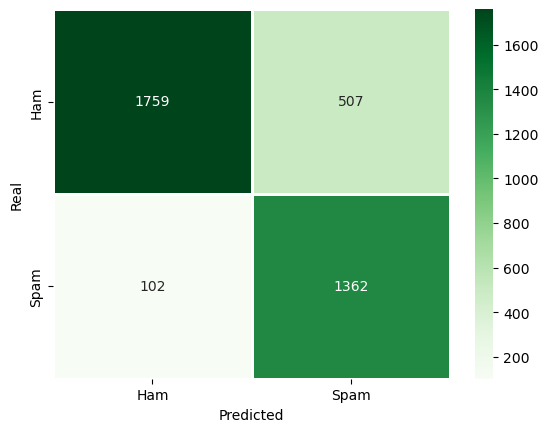

In [19]:
# Naïve Bayes
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB.fit(x_train,y_train)

print_stats(NB)

Accuracy on training data: 95.40%
Accuracy on testing data: 94.50%
Precision: 96.45%
Recall: 90.22%
F1 Score: 93.23%


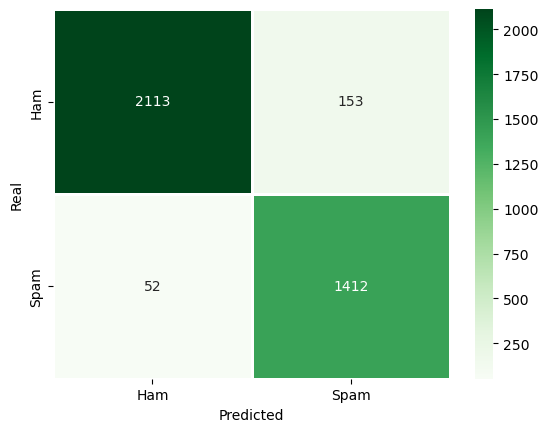

In [20]:
from sklearn.naive_bayes import MultinomialNB
MNB = MultinomialNB()
MNB.fit(x_train,y_train)


print_stats(MNB)

Accuracy on training data: 98.83%
Accuracy on testing data: 96.73%
Precision: 97.95%
Recall: 93.97%
F1 Score: 95.92%


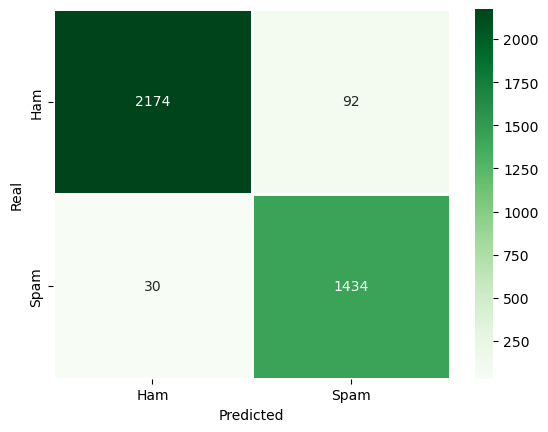

In [21]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(max_iter=1000)
LR.fit(x_train, y_train)

print_stats(LR)

In [22]:
# very long and not very accurate, 12 minutes
# from sklearn.neighbors import KNeighborsClassifier
# KNN = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)
# KNN.fit(x_train, y_train)

# print_stats(KNN)

Accuracy on training data: 94.97%
Accuracy on testing data: 94.34%
Precision: 90.37%
Recall: 94.97%
F1 Score: 92.61%


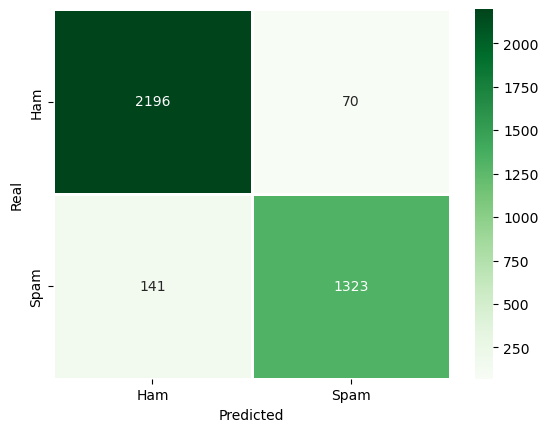

In [23]:
from sklearn.svm import LinearSVC
SVM = LinearSVC(C=0.0001)
SVM.fit(x_train, y_train)

print_stats(SVM)

In [24]:
# 4 minutes
# from sklearn.tree import DecisionTreeClassifier
# CLF = DecisionTreeClassifier()
# CLF.fit(x_train, y_train)

# print_stats(CLF)

Accuracy on training data: 80.19%
Accuracy on testing data: 79.01%
Precision: 46.93%
Recall: 99.13%
F1 Score: 63.70%


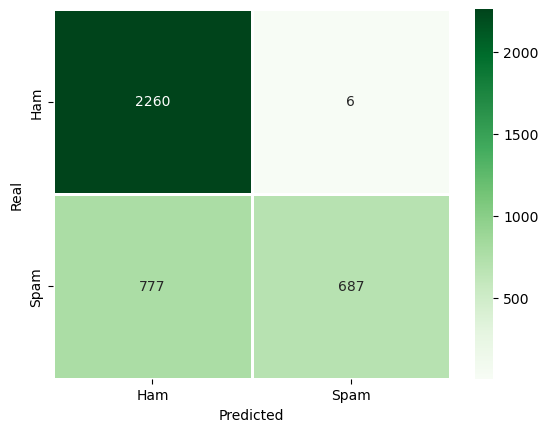

In [25]:
from sklearn.ensemble import RandomForestClassifier
# n_estimators = number of decision trees
RF = RandomForestClassifier(n_estimators=30, max_depth=9)
RF.fit(x_train, y_train)

print_stats(RF)

Accuracy on training data: 95.64%
Accuracy on testing data: 94.53%
Precision: 87.57%
Recall: 98.31%
F1 Score: 92.63%


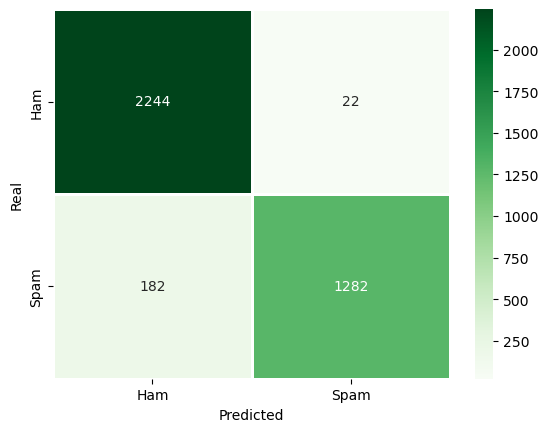

In [26]:
# Voting Classifier
from sklearn.ensemble import VotingClassifier
EVC = VotingClassifier(estimators=[('MNB',MNB),('LR',LR),('RF',RF),('SVM',SVM)], voting='hard')
EVC.fit(x_train, y_train)

print_stats(EVC)